In [1]:
import wave
import numpy as np
import matplotlib.pyplot as plt

In [19]:
# Function to read WAV file and return signal, sample rate, and time array
def read_wave(file_path):
    with wave.open(file_path, 'r') as wf:
        # Extract audio data
        n_frames = wf.getnframes()
        n_channels = wf.getnchannels()
        sample_width = wf.getsampwidth()
        sample_rate = wf.getframerate()
        

        # Read frames and convert to numpy array
        frames = wf.readframes(n_frames)
        signal = np.frombuffer(frames, dtype=np.int32)  # Assuming 32-bit WAV files
        signal = signal/np.max(np.abs(signal))

        # If stereo, take only one channel
        if n_channels > 1:
            signal = signal[::n_channels]

        # Create time array
        time = np.linspace(0, n_frames / sample_rate, num=n_frames)
        

    return signal, sample_rate, time





In [20]:
def peak_finder(signal, time):
    # Find peaks
    peaks = []
    peak_times = []
    for i in range(1, len(signal) - 1):
        if signal[i - 1] < signal[i] and signal[i] > signal[i + 1]:
            peaks.append(signal[i])
            peak_times.append(time[i])

    return peak_times, peaks

Mean frequency: 4774.044725679598


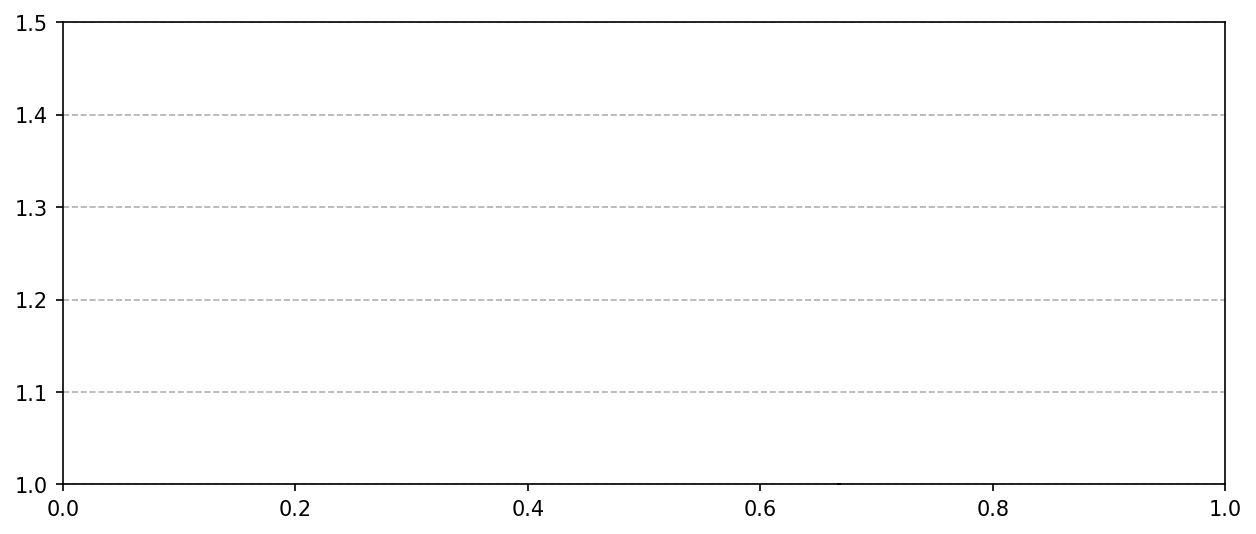

In [21]:
signal, sample_rate, time = read_wave('trial.wav')

peak_times, peaks = peak_finder(signal, time)
freq_mean = 1/np.mean(np.diff(peak_times))
print('Mean frequency:', freq_mean)



# Plot signal
plt.figure(figsize=(10, 4), dpi = 150)
plt.plot(time, signal, color='black', ls='-', marker='.', linewidth = 0.2, markersize=0.5)
#plt.plot(peak_times, peaks, color='red', ls='', marker='o', markersize=2)
plt.xlim(0, 1)
plt.ylim(1, 1.5)

# horizontal gridlines
plt.grid(axis='y', linestyle='--')

